## PROJECT: US Airline Sentiment Analysis

__Task:__ Classify tweets (feeback) as either _positive_, _negative_, or _neutral_ feedback

In [1]:
# loading relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from re import sub
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from matplotlib.image import imread
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# custom color map : >> credit: https://www.youtube.com/watch?v=qk0n-YaKIkY >> https://coolors.co/palettes/trending

from matplotlib.colors import LinearSegmentedColormap
mycmap = LinearSegmentedColormap.from_list('mycmap',['#543005','#bf812d'], N=15)

favcols = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']

randomstate = 1

### Loading Dataset

In [3]:
flight = pd.read_csv('./dataset/Tweets.csv',
                     parse_dates=['tweet_created'])
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype                                 
---  ------                        --------------  -----                                 
 0   tweet_id                      14640 non-null  int64                                 
 1   airline_sentiment             14640 non-null  object                                
 2   airline_sentiment_confidence  14640 non-null  float64                               
 3   negativereason                9178 non-null   object                                
 4   negativereason_confidence     10522 non-null  float64                               
 5   airline                       14640 non-null  object                                
 6   airline_sentiment_gold        40 non-null     object                                
 7   name                          14640 non-null  object                        

In [4]:
flight.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


### Data Quality Report

In [5]:
# features with 10 or less unique entries

cols_less11 = []
cols = flight.columns
for feature in cols:
    if flight[feature].nunique() < 11:
        cols_less11.append(feature)
cols_less11

['airline_sentiment', 'negativereason', 'airline', 'airline_sentiment_gold']

In [6]:
# data quality report for features with 10 or less unique entries

report = pd.DataFrame()
for idx, feature in enumerate(cols_less11):
    dqr = pd.DataFrame()
    dqr['Features'] = [ feature ]
    dqr['Count'] = [ flight[feature].shape[0] ]
    dqr['Card'] = [ flight[feature].nunique() ]
    dqr['Missing'] = [ flight[feature].isnull().sum() ]
    dqr['Missing %'] = np.around(dqr['Missing'] / dqr['Count'] * 100, 2)
    dqr['1st Mode'] = [ flight[feature].mode(dropna=True)[0] ]
    dqr['1st Mode Freq'] = [ flight[flight[feature] == dqr['1st Mode'][0]].shape[0] ]
    dqr['2nd Mode'] = [ flight[flight[feature] != dqr['1st Mode'][0]][feature].mode(dropna=True)[0] ]
    dqr['2nd Mode Freq'] = [ flight[flight[feature] == dqr['2nd Mode'][0]].shape[0] ]
    report = pd.concat([report, dqr], axis=0, ignore_index=True)

report

,Features,Count,Card,Missing,Missing %,1st Mode,1st Mode Freq,2nd Mode,2nd Mode Freq
0,airline_sentiment,14640,3,0,0.00,negative,9178,neutral,3099
1,negativereason,14640,10,5462,37.31,Customer Service Issue,2910,Late Flight,1665
2,airline,14640,6,0,0.00,United,3822,US Airways,2913
3,airline_sentiment_gold,14640,3,14600,99.73,negative,32,positive,5


### Data Pre Processing

In [7]:
# Dropping features with >= 50% missing values and converting categorical labels to numerical

cols_selected = ['airline', 'negativereason', 'text', 'airline_sentiment']
df = flight[cols_selected].copy()
df.head()

,airline,negativereason,text,airline_sentiment
0,Virgin America,NaN,@VirginAmerica What @dhepburn said.,neutral
1,Virgin America,NaN,@VirginAmerica plus you've added commercials t...,positive
2,Virgin America,NaN,@VirginAmerica I didn't today... Must mean I n...,neutral
3,Virgin America,Bad Flight,@VirginAmerica it's really aggressive to blast...,negative
4,Virgin America,Can't Tell,@VirginAmerica and it's a really big bad thing...,negative


In [8]:
# removing: hyperlinks, tags, emojis, and popular regular expressions

feedbacks = df['text'].to_list()
newfeedbacks = []
regs = ('http','@','#',':','&')
for tweet in feedbacks:
    tweet = tweet.split()
    words = [word.lower() for word in tweet if not word.lower().startswith(regs)]
    newtweet = [" ".join(words)]
    newfeedbacks.append(newtweet)

for id in range(df.shape[0]):
    newfeedbacks[id][0] = sub('[^a-zA-Z]', " ", newfeedbacks[id][0])

# removing extra spaces between words
fb_nospaces = []
for fb in newfeedbacks:
    tweet = " ".join(fb)
    tweet = [" ".join(tweet.split())]
    fb_nospaces.append(tweet)

df['text'] = np.array(fb_nospaces)

In [9]:
# removing stopword from the data set

feedbacks = df['text'].to_list()
no_stopwords = []
for tweet in feedbacks:
    tweet = tweet.split()
    tweet = [word for word in tweet if not len(word) < 3] # removing words with less than three characters
    words = [word for word in " ".join(tweet).split() if not word in stopwords.words('english')]
    newfeedbacks = [" ".join(words)]
    no_stopwords.append(newfeedbacks)

df['text'] = np.array(no_stopwords)
df.head()

,airline,negativereason,text,airline_sentiment
0,Virgin America,NaN,said,neutral
1,Virgin America,NaN,plus added commercials experience tacky,positive
2,Virgin America,NaN,today must mean need take another trip,neutral
3,Virgin America,Bad Flight,really aggressive blast obnoxious entertainmen...,negative
4,Virgin America,Can't Tell,really big bad thing,negative


### Exploratory Data Analysis

In [10]:
eda = df.copy()

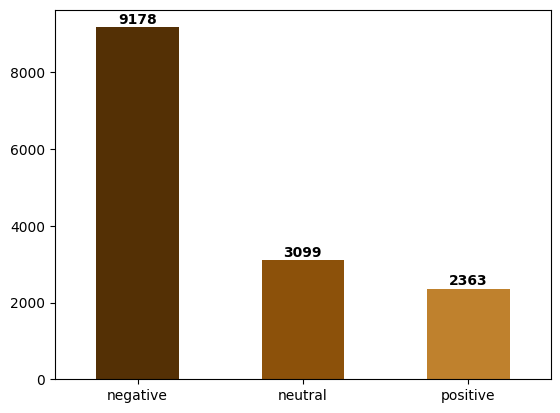

In [11]:
# A chart of sentiments categorized in our dataset

s = ['negative', 'neutral', 'positive']
eda['airline_sentiment'].value_counts().plot(kind='bar', color=favcols)
pos, lab = plt.xticks()
plt.xticks(pos, lab, rotation=0)
for id in range(len(s)):
    plt.text(pos[id], eda[eda['airline_sentiment'] == s[id]].shape[0] + 100, eda[eda['airline_sentiment'] == s[id]].shape[0], ha='center', weight='semibold')
plt.show()

In [12]:
print(lab)

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]


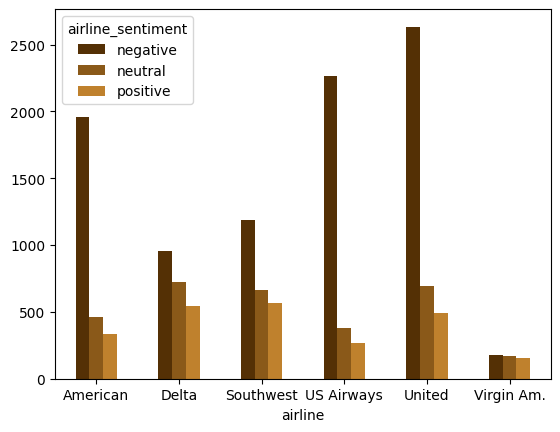

In [13]:
# Number of flights grouped by airline sentiments

airlines = eda.groupby('airline')['airline_sentiment'].value_counts()
airlines.unstack().plot(kind='bar', colormap=mycmap)
pos, lab = plt.xticks()
lab = ['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin Am.']
plt.xticks(pos, lab, rotation=0)
plt.show()

In [14]:
# sentiment counts for each airline

eda.groupby('airline')['airline_sentiment'].agg(['value_counts'])

value_counts
airline        airline_sentiment              
American       negative                   1960
               neutral                     463
               positive                    336
Delta          negative                    955
               neutral                     723
               positive                    544
Southwest      negative                   1186
               neutral                     664
               positive                    570
US Airways     negative                   2263
               neutral                     381
               positive                    269
United         negative                   2633
               neutral                     697
               positive                    492
Virgin America negative                    181
               neutral                     171
               positive                    152

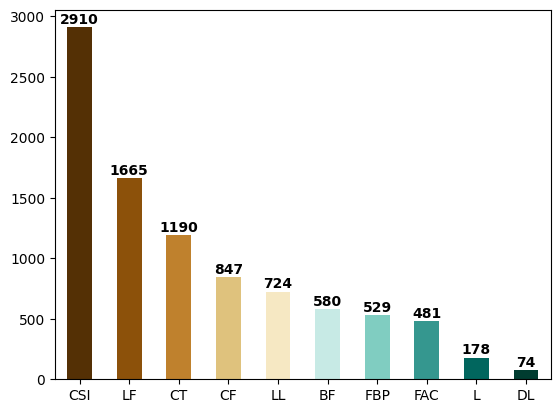

In [15]:
# negative reasons

nreason_abbr = {'Customer Service Issue':'CSI', 'Late Flight':'LF',
                "Can't Tell":'CT', 'Cancelled Flight':'CF',
                'Lost Luggage':'LL', 'Bad Flight':'BF',
                'Flight Booking Problems':'FBP', 'longlines':'L',
                'Flight Attendant Complaints':'FAC','Damaged Luggage':'DL'}

nra = ['Customer Service Issue', 'Late Flight', "Can't Tell",
       'Cancelled Flight', 'Lost Luggage', 'Bad Flight',
       'Flight Booking Problems', 'Flight Attendant Complaints',
       'longlines', 'Damaged Luggage']

eda['negativereason'].map(nreason_abbr).value_counts().plot(kind='bar', color=favcols)
pos, lab = plt.xticks()
plt.xticks(pos, lab, rotation=0)
for id in range(len(nra)):
    plt.text(pos[id], eda[eda['negativereason'] == nra[id]].shape[0] + 30, eda[eda['negativereason'] == nra[id]].shape[0], ha='center', weight='semibold')
plt.show()

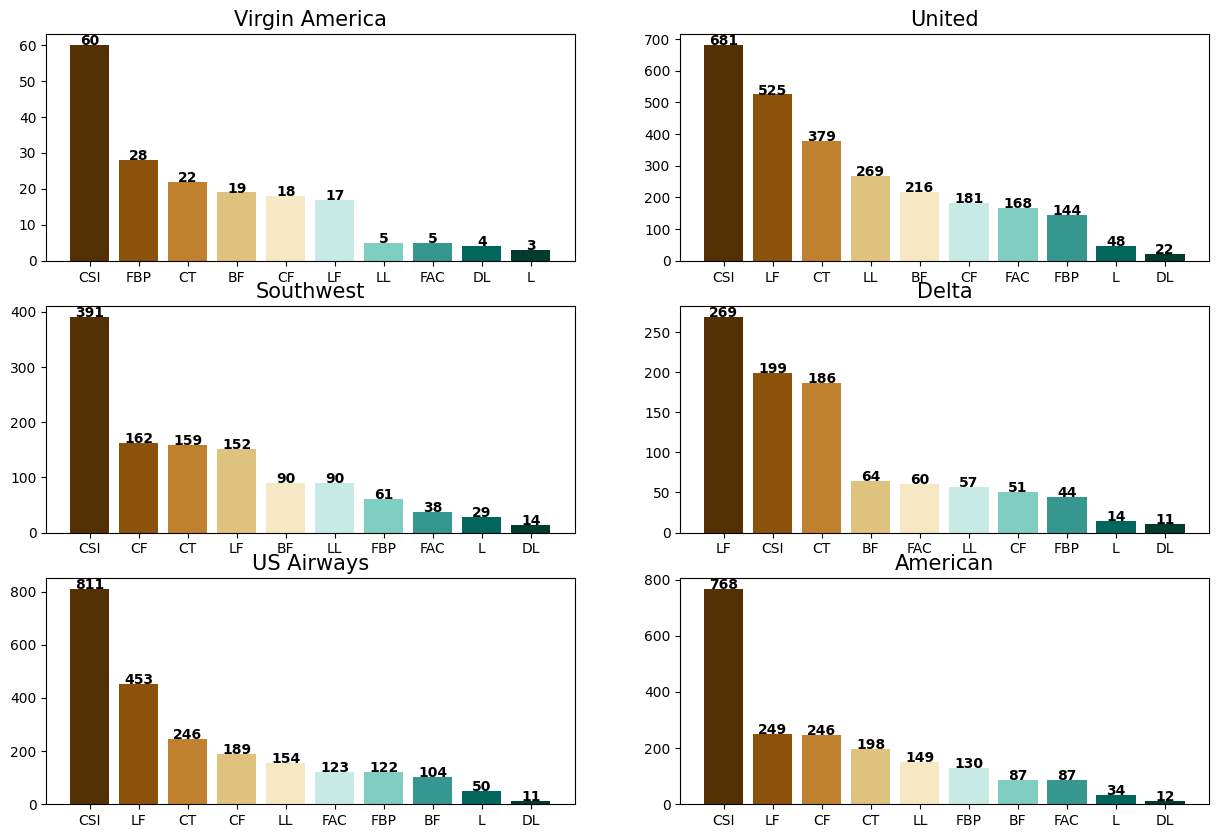

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
airlines = eda.airline.unique()

id = 0
for i in range(3):
    for j in range(2):
        airline = eda[eda.airline == airlines[id]]
        airline['negativereason'] = airline['negativereason'].map(nreason_abbr)
        labs = airline['negativereason'].value_counts().to_dict()
        x, y = list(labs.keys()), list(labs.values())
        axs[i,j].bar(x=x, height=y, color=favcols)
        axs[i,j].set_title(airlines[id], fontsize=15)
        for idx in range(len(nra)):
            axs[i,j].text(idx, airline[airline['negativereason'] == x[idx]].shape[0], airline[airline['negativereason'] == x[idx]].shape[0], ha='center', weight='semibold')
        id += 1

In [17]:
# negative reasons for each airline

eda.groupby('airline')['negativereason'].agg(['value_counts'])

value_counts
airline        negativereason                           
American       Customer Service Issue                768
               Late Flight                           249
               Cancelled Flight                      246
               Can't Tell                            198
               Lost Luggage                          149
               Flight Booking Problems               130
               Bad Flight                             87
               Flight Attendant Complaints            87
               longlines                              34
               Damaged Luggage                        12
Delta          Late Flight                           269
               Customer Service Issue                199
               Can't Tell                            186
               Bad Flight                             64
               Flight Attendant Complaints            60
               Lost Luggage                           57
               Cancelled Flight                       51
               Flight Booking Problems                44
               longlines                              14
               Damaged Luggage                        11
Southwest      Customer Service Issue                391
               Cancelled Flight                      162
               Can't Tell                            159
               Late Flight                           152
               Bad Flight                             90
               Lost Luggage                           90
               Flight Booking Problems                61
               Flight Attendant Complaints            38
               longlines                              29
               Damaged Luggage                        14
US Airways     Customer Service Issue                811
               Late Flight                           453
               Can't Tell                            246
               Cancelled Flight                      189
               Lost Luggage                          154
               Flight Attendant Complaints           123
               Flight Booking Problems               122
               Bad Flight                            104
               longlines                              50
               Damaged Luggage                        11
United         Customer Service Issue                681
               Late Flight                           525
               Can't Tell                            379
               Lost Luggage                          269
               Bad Flight                            216
               Cancelled Flight                      181
               Flight Attendant Complaints           168
               Flight Booking Problems               144
               longlines                              48
               Damaged Luggage                        22
Virgin America Customer Service Issue                 60
               Flight Booking Problems                28
               Can't Tell                             22
               Bad Flight                             19
               Cancelled Flight                       18
               Late Flight                            17
               Flight Attendant Complaints             5
               Lost Luggage                            5
               Damaged Luggage                         4
               longlines                               3

In [18]:
# creating a mask for wordcloud
# credit: https://www.datacamp.com/tutorial/wordcloud-python >> image: https://www.vecteezy.com/png/1208393-plane

planemask = imread('./images/plane.png')
planemask = np.mean(planemask, -1) # convert to grayscale

# transforming our plane mask
def transform_format(mask):
    if mask == 0:
        return 255
    else:
        return 1

transformed_planemask = np.ndarray((planemask.shape[0],
                                    planemask.shape[1]), np.int32)
for i in range(len(planemask)):
    transformed_planemask[i] = list(map(transform_format,
                                        planemask[i]))

planemask = transformed_planemask

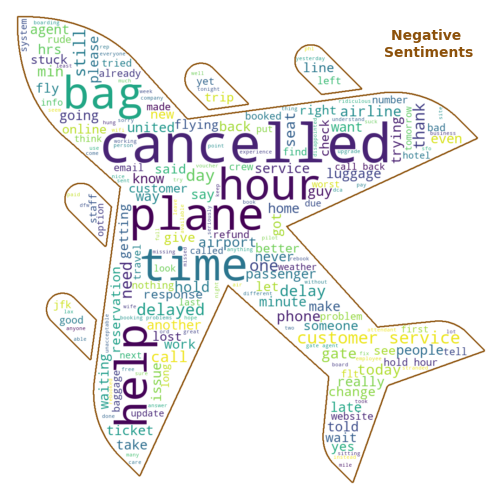

In [19]:
# word cloud for negative sentiments
tweets = df[df['airline_sentiment'] == 'negative']
# taking out the occurance of 'flight' since this is a flight data set and thus will appear in alot of tweets
wctexts = " ".join([word for word in " ".join(tweets['text']).split() if not word.startswith('flight')])
wc = WordCloud(mask=planemask, background_color='white',
               contour_width=3, contour_color=favcols[1],
               random_state=randomstate, min_font_size=1).generate(wctexts)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.text(900, 100, 'Negative \nSentiments', ha='center', weight='semibold', color=favcols[1])
plt.tight_layout(pad=0)
plt.show()
wc.to_file('./images/negemowc.png')

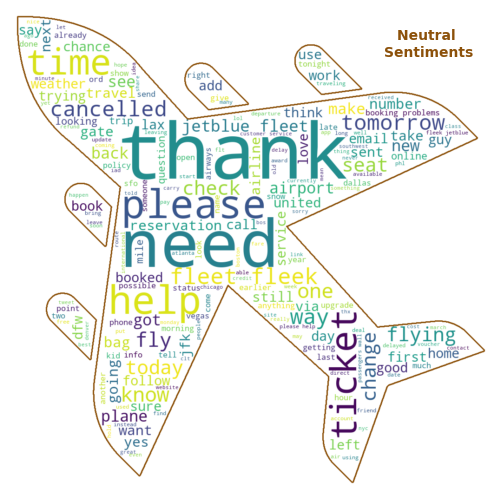

In [20]:
# word cloud for neutral sentiments
tweets = df[df['airline_sentiment'] == 'neutral']
# taking out the occurance of 'flight' since this is a flight data set and thus will appear in alot of tweets
wctexts = " ".join([word for word in " ".join(tweets['text']).split() if not word.startswith('flight')])
wc = WordCloud(mask=planemask, background_color='white',
               contour_width=3, contour_color=favcols[1],
               random_state=randomstate, min_font_size=1).generate(wctexts)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.text(900, 100, 'Neutral \nSentiments', ha='center', weight='semibold', color=favcols[1])
plt.tight_layout(pad=0)
plt.show()
wc.to_file('./images/neuemowc.png')

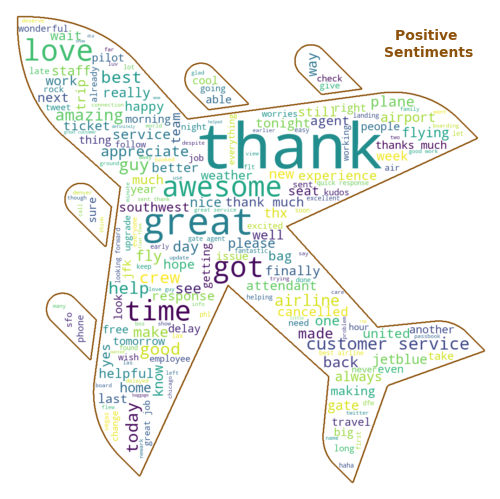

In [21]:
# word cloud for positive sentiments
tweets = df[df['airline_sentiment'] == 'positive']
# taking out the occurance of 'flight' since this is a flight data set and thus will appear in alot of tweets
wctexts = " ".join([word for word in " ".join(tweets['text']).split() if not word.startswith('flight')])
wc = WordCloud(mask=planemask, background_color='white',
               contour_width=3, contour_color=favcols[1],
               random_state=randomstate, min_font_size=1).generate(wctexts)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.text(900, 100, 'Positive \nSentiments', ha='center', weight='semibold', color=favcols[1])
plt.tight_layout(pad=0)
plt.show()
wc.to_file('./images/posemowc.png')

### Modelling
1. Logistic Regression
2. Support Vector Machine
3. Naive Bayes Classification

In [22]:
ts = .2 # test size for train test split

In [23]:
# generating datasets

mdldf = df[['text', 'airline_sentiment']].copy()
sentiments_labels = {'negative':-1, 'neutral':0, 'positive':1}
mdldf['airline_sentiment'] = mdldf['airline_sentiment'].map(sentiments_labels)

X_train, X_test, ytrain, ytest = train_test_split(
                                                mdldf['text'],
                                                mdldf['airline_sentiment'],
                                                test_size=ts,
                                                stratify=mdldf['airline_sentiment'],
                                                shuffle=True,
                                                random_state=randomstate)

print(f'Training size: {X_train.shape} \nTesting size: {X_test.shape}')

Training size: (11712,) 
Testing size: (2928,)


In [24]:
# vectorizing 'text' into bag of words

bow = CountVectorizer(binary=True)
Xtrain = bow.fit_transform(X_train)
Xtest = bow.transform(X_test)

In [25]:
len(bow.vocabulary_)

8556

In [26]:
Xtrain.toarray().shape

(11712, 8556)

### Logistic Regression

Train Accuracy Score = 92.18%
Test Accuracy Score = 78.89%


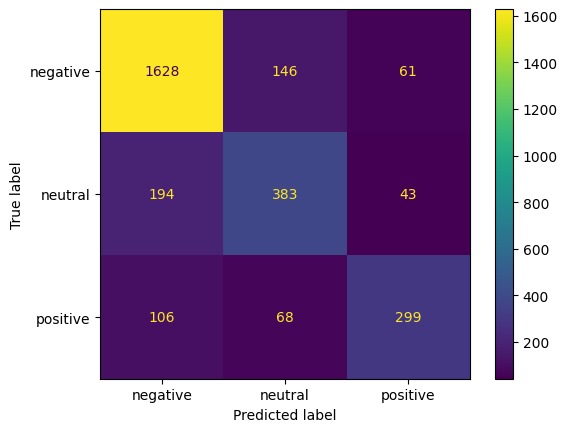

              precision    recall  f1-score   support

          -1       0.84      0.89      0.87      1835
           0       0.64      0.62      0.63       620
           1       0.74      0.63      0.68       473

    accuracy                           0.79      2928
   macro avg       0.74      0.71      0.73      2928
weighted avg       0.78      0.79      0.79      2928



In [27]:
lrmdl = LogisticRegression()
lrmdl.fit(Xtrain, ytrain)
ypred_lr = lrmdl.predict(Xtest)
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, lrmdl.predict(Xtrain) ) * 100) )
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_lr) * 100) )

# confusion matrix
cmatrix = confusion_matrix(ytest, ypred_lr)
cmatrix_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=sentiments_labels.keys())
cmatrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_lr))

### Support Vector Machine

Train Accuracy Score = 91.69%
Test Accuracy Score = 78.62%


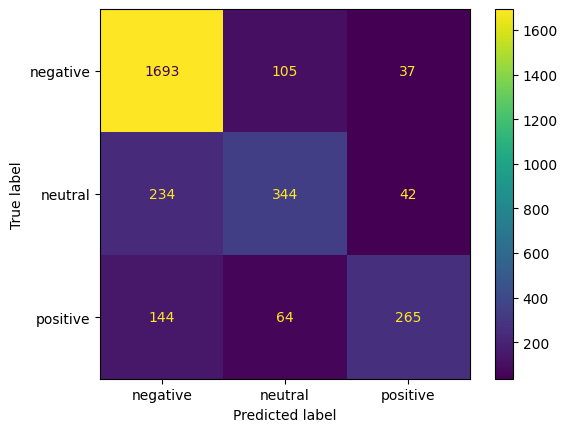

              precision    recall  f1-score   support

          -1       0.82      0.92      0.87      1835
           0       0.67      0.55      0.61       620
           1       0.77      0.56      0.65       473

    accuracy                           0.79      2928
   macro avg       0.75      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928



In [28]:
svmmdl = SVC()
svmmdl.fit(Xtrain, ytrain)
ypred_svm = svmmdl.predict(Xtest)
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, svmmdl.predict(Xtrain) ) * 100) )
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_svm) * 100) )

# confusion matrix
cmatrix = confusion_matrix(ytest, ypred_svm)
cmatrix_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=sentiments_labels.keys())
cmatrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_svm))

### Naive Bayes

Train Accuracy Score = 83.64%
Test Accuracy Score = 75.61%


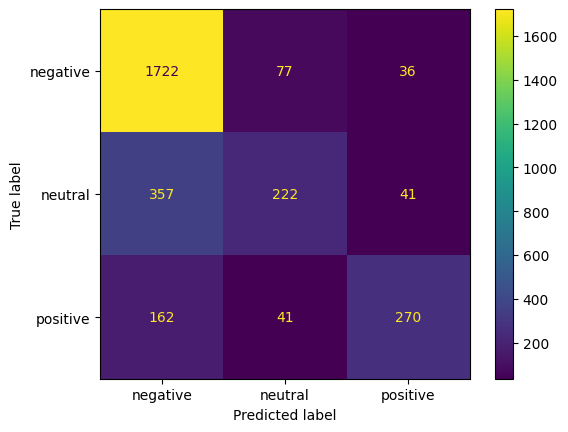

              precision    recall  f1-score   support

          -1       0.77      0.94      0.84      1835
           0       0.65      0.36      0.46       620
           1       0.78      0.57      0.66       473

    accuracy                           0.76      2928
   macro avg       0.73      0.62      0.66      2928
weighted avg       0.75      0.76      0.73      2928



In [29]:
nbmdl = MultinomialNB()
nbmdl.fit(Xtrain, ytrain)
ypred_nb = nbmdl.predict(Xtest)
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, nbmdl.predict(Xtrain) ) * 100) )
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_nb) * 100) )

# confusion matrix
cmatrix = confusion_matrix(ytest, ypred_nb)
cmatrix_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=sentiments_labels.keys())
cmatrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_nb))

### Tunning Model:

### Stemming

In [30]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
mdldf_2 = mdldf.copy()

In [32]:
# Reducing words to their root word >> credit: https://www.geeksforgeeks.org/introduction-to-nltk-tokenization-stemming-lemmatization-pos-tagging/

wnl = WordNetLemmatizer()
texts = mdldf_2['text'].to_list()
wnl_texts = []
for tweet in texts:
    nouns = [wnl.lemmatize(word, 'n') for word in tweet.split() if wnl] # reduce nouns
    verbs = [wnl.lemmatize(word, 'v') for word in " ".join(nouns).split() if wnl] # reduce verbs
    wnl_texts.append(" ".join(verbs))

mdldf_2['text'] = wnl_texts
mdldf_2.head()

,text,airline_sentiment
0,say,0
1,plus add commercial experience tacky,1
2,today must mean need take another trip,0
3,really aggressive blast obnoxious entertainmen...,-1
4,really big bad thing,-1


In [33]:
# generating datasets

X_train, X_test, ytrain, ytest = train_test_split(
                                                mdldf_2['text'],
                                                mdldf_2['airline_sentiment'],
                                                test_size=ts,
                                                stratify=mdldf_2['airline_sentiment'],
                                                random_state=randomstate)

print(f'Training size: {X_train.shape} \nTesting size: {X_test.shape}')

Training size: (11712,) 
Testing size: (2928,)


In [34]:
# vectorizing 'text' into ngram bag of words

bow = CountVectorizer(binary=True, ngram_range=(1,2))
Xtrain = bow.fit_transform(X_train)
Xtest = bow.transform(X_test)

In [35]:
Xtrain.toarray().shape

(11712, 61100)

### Logistic Regression

Train Accuracy Score = 98.39%
Test Accuracy Score = 80.40%


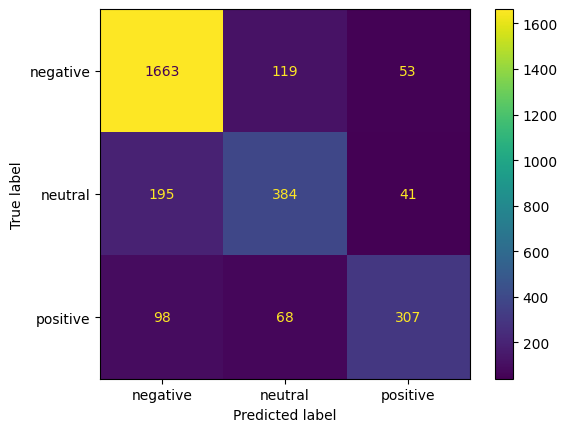

              precision    recall  f1-score   support

          -1       0.85      0.91      0.88      1835
           0       0.67      0.62      0.64       620
           1       0.77      0.65      0.70       473

    accuracy                           0.80      2928
   macro avg       0.76      0.72      0.74      2928
weighted avg       0.80      0.80      0.80      2928



In [36]:
lrmdl = LogisticRegression()
lrmdl.fit(Xtrain, ytrain)
ypred_lr = lrmdl.predict(Xtest)
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, lrmdl.predict(Xtrain) ) * 100) )
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_lr) * 100) )

# confusion matrix
cmatrix = confusion_matrix(ytest, ypred_lr)
cmatrix_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=sentiments_labels.keys())
cmatrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_lr))

### Support Vector Machine

Train Accuracy Score = 93.16%
Test Accuracy Score = 77.60%


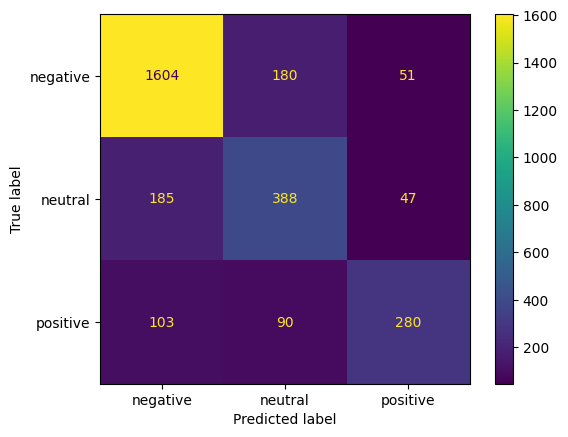

              precision    recall  f1-score   support

          -1       0.85      0.87      0.86      1835
           0       0.59      0.63      0.61       620
           1       0.74      0.59      0.66       473

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.77      2928



In [37]:
svmmdl = SVC()
svmmdl.fit(Xtrain, ytrain)
ypred_svm = svmmdl.predict(Xtest)
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, svmmdl.predict(Xtrain) ) * 100) )
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_svm) * 100) )

# confusion matrix
cmatrix = confusion_matrix(ytest, ypred_svm)
cmatrix_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=sentiments_labels.keys())
cmatrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_svm))

### Naive Bayes

Train Accuracy Score = 91.44%
Test Accuracy Score = 72.75%


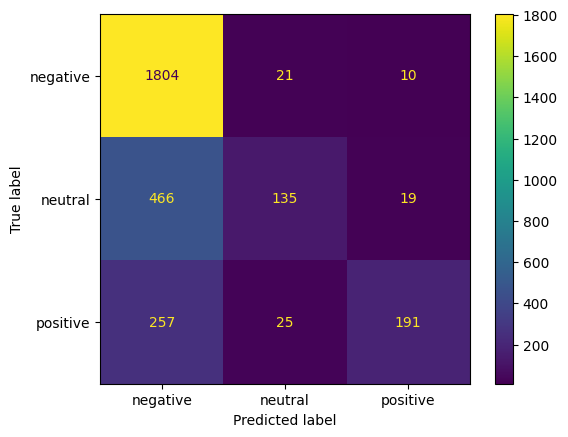

              precision    recall  f1-score   support

          -1       0.71      0.98      0.83      1835
           0       0.75      0.22      0.34       620
           1       0.87      0.40      0.55       473

    accuracy                           0.73      2928
   macro avg       0.78      0.53      0.57      2928
weighted avg       0.75      0.73      0.68      2928



In [38]:
nbmdl = MultinomialNB()
nbmdl.fit(Xtrain, ytrain)
ypred_nb = nbmdl.predict(Xtest)
print('Train Accuracy Score = {:.2f}%'.format(accuracy_score(ytrain, nbmdl.predict(Xtrain) ) * 100) )
print('Test Accuracy Score = {:.2f}%'.format(accuracy_score(ytest, ypred_nb) * 100) )

# confusion matrix
cmatrix = confusion_matrix(ytest, ypred_nb)
cmatrix_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=sentiments_labels.keys())
cmatrix_display.plot()
plt.show()

# evaluation
print(classification_report(ytest, ypred_nb))

In [39]:
len(bow.vocabulary_)

61100